# Importing libraries

In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from PIL import Image
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

torch.manual_seed(42)
np.random.seed(42)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Our implementation of Compact Transformer Model

In [2]:
# MultiHeadAttention Module
class MSA(nn.Module):
    def __init__(self, embedding_dim: int=192, num_heads: int=3, dropout: float=0):
        super().__init__()
        # layer normalization layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        # multiheadattention layer
        self.msa_attention = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                   num_heads=num_heads,
                                                   dropout=dropout,
                                                   batch_first=True)
        
    def forward(self, x):
        x = self.layer_norm(x)
        # query, key, value are formed from the same x
        x, _ = self.msa_attention(query=x,
                                    key=x,
                                    value=x,
                                    need_weights=False)
        return x
    
# MLP layer   
class MLP(nn.Module):
    def __init__(self, 
                 embedding_dim: int=192,
                 mlp_size: int=768,
                 dropout: float=0.1):
        super().__init__()
        # layer normalization
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        # two linear layers separated by GeLU activation
        self.mlp = nn.Sequential(
                nn.Linear(in_features=embedding_dim,
                        out_features=mlp_size), # from input_dim to mlp_size
                nn.GELU(),
                nn.Dropout(p=dropout),
                nn.Linear(in_features=mlp_size, # from mlp_size to input_dim
                        out_features=embedding_dim),
                nn.Dropout(p=dropout))
        
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        
        return x
        
# Transformer encoder block
class EncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int=192,
                 num_heads: int=3,
                 mlp_size: int=768,
                 mlp_dropout: float=0.1,
                 msa_dropout: float=0.0):
        super().__init__()
        # each block (layer) consists of MSA and MLP
        self.msa = MSA(embedding_dim=embedding_dim,
                       num_heads=num_heads,
                       dropout=msa_dropout)
        
        self.mlp = MLP(embedding_dim=embedding_dim,
                       mlp_size=mlp_size,
                       dropout=mlp_dropout)
        
    def forward(self, x):
        x = self.msa(x) + x # skip connection #1
        x = self.mlp(x) + x # skip connection #2
        
        return x


# taken from CVT-CCT paper
class Tokenizer(nn.Module):
    def __init__(self,
                 kernel_size: int=7, stride: int=2, padding: int=3,
                 pooling_kernel_size: int=3, pooling_stride: int=2, pooling_padding: int=1,
                 conv_layers: int=2, input_channels: int=3, 
                 output_channels: int=64, in_planes: int=64):
        super().__init__()

        self.conv1 = nn.Conv2d(input_channels, in_planes, 
                               kernel_size=(kernel_size, kernel_size),
                               stride=(stride, stride),
                               padding=(padding, padding), bias=False)
        
        self.max_pool = nn.MaxPool2d(kernel_size=pooling_kernel_size,
                                     stride=pooling_stride,
                                     padding=pooling_padding)
        
        self.conv2 = nn.Conv2d(in_planes, in_planes+in_planes,       # TODO change
                               kernel_size=(kernel_size, kernel_size),
                               stride=(stride, stride),
                               padding=(padding, padding), bias=False)
        
        self.conv3 = nn.Conv2d(in_planes+in_planes, output_channels,
                               kernel_size=(kernel_size, kernel_size),
                               stride=(stride, stride),
                               padding=(padding, padding), bias=False)

        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.max_pool(x)
        x = self.conv2(x)
        x = self.max_pool(x)
        x = self.conv3(x)
        x = self.flatten(x)
        
        return x.permute(0, 2, 1)


class CvT(nn.Module):
    def __init__(self,
                 img_size: int=224, in_channels: int=3, kernel_size: int=7,
                 layers: int=7, embedding_dim: int=256, mlp_size: int=512,
                 num_heads: int=4, stride: int=2, padding: int=3,
                 pooling_kernel_size: int=3, pooling_stride: int=2, pooling_padding :int=1,
                 conv_layers: int=2, in_planes: int=64,
                 msa_dropout: float=0.0, mlp_dropout: float=0.1,
                 emb_dropout: float=0.1, num_classes: int=10):
        super().__init__()
        
        self.tokenizer = Tokenizer(kernel_size=kernel_size, stride=stride, 
                                   padding=padding, pooling_kernel_size=pooling_kernel_size, 
                                   pooling_stride=pooling_stride, pooling_padding=pooling_padding, 
                                   conv_layers=conv_layers, input_channels=in_channels, 
                                   output_channels=embedding_dim, in_planes=in_planes)
        
        self.attention_pool = nn.Linear(embedding_dim, 1)
        
        self.emb_dropout = nn.Dropout(p=emb_dropout)
        
        self.encoder = nn.Sequential(*[
            EncoderBlock(embedding_dim=embedding_dim,
                         num_heads=num_heads,
                         mlp_size=mlp_size,
                         mlp_dropout=mlp_dropout,
                         msa_dropout=msa_dropout)
            for _ in range(layers)
        ])
        
        self.norm = nn.LayerNorm(embedding_dim)
        
        self.head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        x = self.tokenizer(x)
        x = self.emb_dropout(x)
        x = self.encoder(x)
        x = self.norm(x)
        x = torch.matmul(F.softmax(self.attention_pool(x), dim=1).transpose(-1, -2), x).squeeze(-2)
        x = self.head(x)
        
        return x
    
class CvT_3(CvT):
    def __init__(self,
                 img_size: int=224, in_channels: int=3, kernel_size: int=7,
                 layers: int=3, embedding_dim: int=192, mlp_size: int=384,
                 num_heads: int=3, stride: int=2, padding: int=3,
                 pooling_kernel_size: int=3, pooling_stride: int=2, pooling_padding :int=1,
                 conv_layers: int=2, in_planes: int=64,
                 msa_dropout: float=0.0, mlp_dropout: float=0.1,
                 emb_dropout: float=0.1, num_classes: int=10):
        super().__init__(layers=layers, embedding_dim=embedding_dim, 
                         mlp_size=mlp_size, num_heads=num_heads)
    
class CvT_7(CvT):
    def __init__(self,
                 img_size: int=224, in_channels: int=3, kernel_size: int=7,
                 layers: int=7, embedding_dim: int=256, mlp_size: int=512,
                 num_heads: int=4, stride: int=2, padding: int=3,
                 pooling_kernel_size: int=3, pooling_stride: int=2, pooling_padding :int=1,
                 conv_layers: int=2, in_planes: int=64,
                 msa_dropout: float=0.0, mlp_dropout: float=0.1,
                 emb_dropout: float=0.1, num_classes: int=10):
        super().__init__(layers=layers, embedding_dim=embedding_dim, 
                         mlp_size=mlp_size, num_heads=num_heads)
    
class CvT_14(CvT):
    def __init__(self,
                 img_size: int=224, in_channels: int=3, kernel_size: int=7,
                 layers: int=14, embedding_dim: int=384, mlp_size: int=1152,
                 num_heads: int=6, stride: int=2, padding: int=3,
                 pooling_kernel_size: int=3, pooling_stride: int=2, pooling_padding :int=1,
                 conv_layers: int=2, in_planes: int=64,
                 msa_dropout: float=0.0, mlp_dropout: float=0.1,
                 emb_dropout: float=0.1, num_classes: int=10):
        super().__init__(layers=layers, embedding_dim=embedding_dim, 
                         mlp_size=mlp_size, num_heads=num_heads)

# Setting up config Parameters

In [3]:
config = {
    'ROOT_DIR': '/kaggle/input/state-farm-distracted-driver-detection/imgs/train',
    'TEST_DIR': '/kaggle/input/state-farm-distracted-driver-detection/imgs/test',
    'MODELS_DIR': '/kaggle/working/',
    'IMG_SIZE': 224,
    'BATCH_SIZE': 64,
    'EPOCHS': 100,
    'PATIENCE': 7,
    'LR_INIT': 1e-4,
    'WEIGHT_DECAY': 5e-3,
    'NUM_CLASSES': 10,
    'NUM_WORKERS': 4,
    'NUM_CHANNELS': 3,
    'DEVICE': torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'),
}

# Utility Functions

In [4]:
# train transformations
train_transforms = transforms.Compose([
    transforms.Resize((config['IMG_SIZE'], config['IMG_SIZE'])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-30, 30)),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])

# val/test/inference transformations
val_transforms = transforms.Compose([
    transforms.Resize((config['IMG_SIZE'], config['IMG_SIZE'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])


def get_images_labels():
    images = []
    labels = []

    for label in list(glob(os.path.join(config['ROOT_DIR'], '*'))):
        imgs_paths = list(glob(os.path.join(config['ROOT_DIR'], label, '*.jpg')))
        labels.extend([int(label[-1]) for i in range(len(imgs_paths))])
        images.extend([image for image in imgs_paths])
    
    return images, labels


class CNNCustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        super().__init__()
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # getting the path to one image
        img_path = self.images[index]

        image = Image.open(img_path).convert('RGB')
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label


In [5]:
def get_dataloaders():
    train_transformations = train_transforms
    val_transformations = val_transforms

    all_images, all_labels = get_images_labels()
    train_images, val_images, train_labels, val_labels = train_test_split(all_images,
                                                                          all_labels,
                                                                          test_size=0.2,
                                                                          random_state=42)
    
    train_dataset = CNNCustomDataset(train_images, train_labels, transform=train_transformations)
    val_dataset = CNNCustomDataset(val_images, val_labels, transform=val_transformations)

    train_loader = DataLoader(train_dataset, batch_size=config['BATCH_SIZE'], shuffle=True, num_workers=config['NUM_WORKERS'])
    val_loader = DataLoader(val_dataset, batch_size=config['BATCH_SIZE'], shuffle=False, num_workers=config['NUM_WORKERS'])

    return train_loader, val_loader

In [6]:
def adjust_learning_rate(optimizer, epoch, warmup=False, warmup_ep=0, enable_cos=True):
    lr = config['LR_INIT']
    if warmup and epoch < warmup_ep:
        lr = lr / (warmup_ep - epoch)
    elif enable_cos:
        lr *= 0.5 * (1. + math.cos(math.pi * (epoch - warmup_ep) / (config['EPOCHS'] - warmup_ep)))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [7]:
def get_metrics(labels, preds):
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return accuracy, precision, recall, f1

In [8]:
def save_graphs(train, test, type='None'):
    plt.figure(figsize=(10,5))
    plt.title(f"Training and Test {type}")
    plt.plot(test,label="valid")
    plt.plot(train,label="train")
    plt.xlabel("Epoch")
    plt.ylabel(f"{type}")
    plt.legend()
    plt.savefig(f'{type}.png')

# Training Functions

In [9]:
def train(train_loader, model, loss_fn, optimizer, epoch, device):
    model.train()

    predictions = []
    all_labels = []
    total_loss = 0.0

    for data in tqdm(train_loader, desc='Training'):
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        # get predictions as the index of max logit
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
        total_loss += loss.item()
    
    accuracy, precision, recall, f1 = get_metrics(all_labels, predictions)
    avg_loss = total_loss / len(train_loader)

    print(f'Epoch {epoch} | Train Loss: {avg_loss} | Accuracy: {accuracy} | Precision: {precision} | Recall: {recall} | F1: {f1}')
    return avg_loss, accuracy, precision, recall, f1

In [10]:
def evaluate(val_loader, model, loss_fn, device):
    model.eval()

    predictions = []
    all_labels = []
    total_loss = 0.0

    for data in tqdm(val_loader, desc='Validating'):
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)

        with torch.no_grad():
            logits = model(imgs)
            loss = loss_fn(logits, labels)

        # get predictions as the index of max logit
        preds = torch.argmax(logits, dim=1)
        predictions.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())
        total_loss += loss.item()
    
    accuracy, precision, recall, f1 = get_metrics(all_labels, predictions)
    avg_loss = total_loss / len(val_loader)

    print(f'\tValidation Loss: {avg_loss} | Accuracy: {accuracy} | Precision: {precision} | Recall: {recall} | F1: {f1}')
    return avg_loss, accuracy, precision, recall, f1

In [11]:
def run_training(train_loader, val_loader, model, model_name, loss_fn, optimizer, config):
    TRAIN_HISTORY = {
        'Loss': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': []
    }
    VAL_HISTORY = {
        'Loss': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1': []
    }

    # for early stopping
    # we will save the best model based on the validation loss
    best_loss = np.inf  # set to infinity so that the first validation loss is always lower
    patience_counter = 0

    for epoch in range(config['EPOCHS']):
        adjust_learning_rate(optimizer=optimizer, epoch=epoch)
        loss, accuracy, precision, recall, f1 = train(train_loader, model, loss_fn, optimizer, epoch + 1, config['DEVICE'])
        TRAIN_HISTORY['Loss'].append(loss)
        TRAIN_HISTORY['Accuracy'].append(accuracy)
        TRAIN_HISTORY['Precision'].append(precision)
        TRAIN_HISTORY['Recall'].append(recall)
        TRAIN_HISTORY['F1'].append(f1)

        loss, accuracy, precision, recall, f1 = evaluate(val_loader, model, loss_fn, config['DEVICE'])
        VAL_HISTORY['Loss'].append(loss)
        VAL_HISTORY['Accuracy'].append(accuracy)
        VAL_HISTORY['Precision'].append(precision)
        VAL_HISTORY['Recall'].append(recall)
        VAL_HISTORY['F1'].append(f1)

        # since our evaluation metric is logloss, we want to minimize it and early stopping will be based on it
        if loss < best_loss:
            best_loss = loss
            patience_counter = 0
            print(f'Saving best model at epoch {epoch + 1}...')
            torch.save(model.state_dict(), f'{model_name}_best_model.pth')
        else:
            patience_counter += 1
            if patience_counter == config['PATIENCE']:
                print(f"Early stopping at epoch {epoch + 1}")
                break
        
    save_graphs(TRAIN_HISTORY['Loss'], VAL_HISTORY['Loss'], type='Loss')
    save_graphs(TRAIN_HISTORY['Accuracy'], VAL_HISTORY['Accuracy'], type='Accuracy')
    save_graphs(TRAIN_HISTORY['F1'], VAL_HISTORY['F1'], type='F1')
    
    print('Training finished!')
    return TRAIN_HISTORY, VAL_HISTORY

# Model, Optimizer, Criterion

In [12]:
model = CvT_3()
model = model.to(config['DEVICE'])
model_name = "cvt_3"
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=config['LR_INIT'],
                              weight_decay=config['WEIGHT_DECAY'])

train_loader, val_loader = get_dataloaders()

In [13]:
from torchinfo import summary
summary(model=model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
CvT_3 (CvT_3)                                           [32, 3, 224, 224]    [32, 10]             --                   True
├─Tokenizer (tokenizer)                                 [32, 3, 224, 224]    [32, 49, 192]        --                   True
│    └─Conv2d (conv1)                                   [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
│    └─MaxPool2d (max_pool)                             [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─Conv2d (conv2)                                   [32, 64, 56, 56]     [32, 128, 28, 28]    401,408              True
│    └─MaxPool2d (max_pool)                             [32, 128, 28, 28]    [32, 128, 14, 14]    --                   --
│    └─Conv2d (conv3)                                   [32, 128, 14, 14]    [32, 192, 7, 7]      1,204,224            True
│    └─

# Training

Training: 100%|██████████| 281/281 [01:32<00:00,  3.04it/s]


Epoch 1 | Train Loss: 2.2313863641426654 | Accuracy: 0.16154746641395842 | Precision: 0.1612545209876413 | Recall: 0.16154746641395842 | F1: 0.15441630777129092


Validating: 100%|██████████| 71/71 [00:18<00:00,  3.75it/s]


	Validation Loss: 1.7635764471242126 | Accuracy: 0.35986622073578595 | Precision: 0.40830602709905905 | Recall: 0.35986622073578595 | F1: 0.3068230705768535
Saving best model at epoch 1...


Training: 100%|██████████| 281/281 [01:11<00:00,  3.95it/s]


Epoch 2 | Train Loss: 1.3928284229332866 | Accuracy: 0.5149673894865935 | Precision: 0.49945888154482804 | Recall: 0.5149673894865935 | F1: 0.5011255384910153


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.69it/s]


	Validation Loss: 0.9182167825564532 | Accuracy: 0.6945373467112598 | Precision: 0.7240683229483023 | Recall: 0.6945373467112598 | F1: 0.6822041900868914
Saving best model at epoch 2...


Training: 100%|██████████| 281/281 [01:12<00:00,  3.87it/s]


Epoch 3 | Train Loss: 0.8191748389782006 | Accuracy: 0.7314789007191036 | Precision: 0.723972457368017 | Recall: 0.7314789007191036 | F1: 0.7247712080975136


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.37it/s]


	Validation Loss: 0.5534755721898146 | Accuracy: 0.8133779264214047 | Precision: 0.8332805388012303 | Recall: 0.8133779264214047 | F1: 0.8002166376844061
Saving best model at epoch 3...


Training: 100%|██████████| 281/281 [01:13<00:00,  3.84it/s]


Epoch 4 | Train Loss: 0.5238021311492682 | Accuracy: 0.8334355315234963 | Precision: 0.8310774360886501 | Recall: 0.8334355315234963 | F1: 0.8310628954430116


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.68it/s]


	Validation Loss: 0.36883379917749215 | Accuracy: 0.8871794871794871 | Precision: 0.889778989600588 | Recall: 0.8871794871794871 | F1: 0.8834716656362538
Saving best model at epoch 4...


Training: 100%|██████████| 281/281 [01:13<00:00,  3.84it/s]


Epoch 5 | Train Loss: 0.3640234429004778 | Accuracy: 0.8890685099503874 | Precision: 0.887961644072071 | Recall: 0.8890685099503874 | F1: 0.8879786617740365


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.45it/s]


	Validation Loss: 0.26255731987701336 | Accuracy: 0.9215161649944259 | Precision: 0.9243338877081895 | Recall: 0.9215161649944259 | F1: 0.9220443900309521
Saving best model at epoch 5...


Training: 100%|██████████| 281/281 [01:13<00:00,  3.82it/s]


Epoch 6 | Train Loss: 0.27311248740585675 | Accuracy: 0.9173309549027259 | Precision: 0.9168402550224114 | Recall: 0.9173309549027259 | F1: 0.9168699365878676


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.81it/s]


	Validation Loss: 0.204356921548155 | Accuracy: 0.939799331103679 | Precision: 0.9436719316221247 | Recall: 0.939799331103679 | F1: 0.9390385342071976
Saving best model at epoch 6...


Training: 100%|██████████| 281/281 [01:13<00:00,  3.83it/s]


Epoch 7 | Train Loss: 0.22841968021464942 | Accuracy: 0.9318245164167457 | Precision: 0.9314406525876638 | Recall: 0.9318245164167457 | F1: 0.9314425287789266


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.74it/s]


	Validation Loss: 0.17839970098624766 | Accuracy: 0.9464882943143813 | Precision: 0.9488562616226612 | Recall: 0.9464882943143813 | F1: 0.9462524419624757
Saving best model at epoch 7...


Training: 100%|██████████| 281/281 [01:14<00:00,  3.77it/s]


Epoch 8 | Train Loss: 0.18599302248757504 | Accuracy: 0.9468755226043816 | Precision: 0.9466597910681783 | Recall: 0.9468755226043816 | F1: 0.9466682523357848


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.36it/s]


	Validation Loss: 0.12910357113717727 | Accuracy: 0.9636566332218506 | Precision: 0.9639905737415994 | Recall: 0.9636566332218506 | F1: 0.9633908245360756
Saving best model at epoch 8...


Training: 100%|██████████| 281/281 [01:14<00:00,  3.79it/s]


Epoch 9 | Train Loss: 0.1619311188781813 | Accuracy: 0.9528401806120742 | Precision: 0.952676322590886 | Recall: 0.9528401806120742 | F1: 0.9527072116756083


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.60it/s]


	Validation Loss: 0.11322236604149073 | Accuracy: 0.9694537346711259 | Precision: 0.9695021238812694 | Recall: 0.9694537346711259 | F1: 0.9693203704263004
Saving best model at epoch 9...


Training: 100%|██████████| 281/281 [01:12<00:00,  3.89it/s]


Epoch 10 | Train Loss: 0.14147562524336937 | Accuracy: 0.9572997380010034 | Precision: 0.9572095052351093 | Recall: 0.9572997380010034 | F1: 0.9572280196413414


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.50it/s]


	Validation Loss: 0.12827082901773318 | Accuracy: 0.9629877369007804 | Precision: 0.963979255460791 | Recall: 0.9629877369007804 | F1: 0.9627866100590335


Training: 100%|██████████| 281/281 [01:11<00:00,  3.92it/s]


Epoch 11 | Train Loss: 0.12566638206963648 | Accuracy: 0.9624839734656335 | Precision: 0.962375568626693 | Recall: 0.9624839734656335 | F1: 0.9623928206551402


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.30it/s]


	Validation Loss: 0.11700356847436076 | Accuracy: 0.9652173913043478 | Precision: 0.9656548385577097 | Recall: 0.9652173913043478 | F1: 0.964993406292581


Training: 100%|██████████| 281/281 [01:14<00:00,  3.79it/s]


Epoch 12 | Train Loss: 0.11799662225478696 | Accuracy: 0.9648809855621829 | Precision: 0.9648116388956822 | Recall: 0.9648809855621829 | F1: 0.9648169509920045


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.63it/s]


	Validation Loss: 0.10164293154916713 | Accuracy: 0.9716833890746934 | Precision: 0.9724041809054784 | Recall: 0.9716833890746934 | F1: 0.971785756192644
Saving best model at epoch 12...


Training: 100%|██████████| 281/281 [01:16<00:00,  3.68it/s]


Epoch 13 | Train Loss: 0.1134131475752783 | Accuracy: 0.9661631083115001 | Precision: 0.9660974658003743 | Recall: 0.9661631083115001 | F1: 0.9661067043086832


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.63it/s]


	Validation Loss: 0.09966620152265253 | Accuracy: 0.9750278706800446 | Precision: 0.9756252754218434 | Recall: 0.9750278706800446 | F1: 0.9751135113846048
Saving best model at epoch 13...


Training: 100%|██████████| 281/281 [01:16<00:00,  3.69it/s]


Epoch 14 | Train Loss: 0.10543596988470953 | Accuracy: 0.9694520318858353 | Precision: 0.9694435133251114 | Recall: 0.9694520318858353 | F1: 0.9694216393930992


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.50it/s]


	Validation Loss: 0.09243543335879353 | Accuracy: 0.9721293199554069 | Precision: 0.9723388285874814 | Recall: 0.9721293199554069 | F1: 0.9720216291923036
Saving best model at epoch 14...


Training: 100%|██████████| 281/281 [01:14<00:00,  3.76it/s]


Epoch 15 | Train Loss: 0.09132804490586087 | Accuracy: 0.9727409554601706 | Precision: 0.9727134951008364 | Recall: 0.9727409554601706 | F1: 0.9727154247555169


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.53it/s]


	Validation Loss: 0.060503969598613996 | Accuracy: 0.9830546265328874 | Precision: 0.9831070796504988 | Recall: 0.9830546265328874 | F1: 0.9830356149701316
Saving best model at epoch 15...


Training: 100%|██████████| 281/281 [01:15<00:00,  3.74it/s]


Epoch 16 | Train Loss: 0.09422749539777583 | Accuracy: 0.9721277663191928 | Precision: 0.9721226937603281 | Recall: 0.9721277663191928 | F1: 0.9721097396510375


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.73it/s]


	Validation Loss: 0.09022179930667643 | Accuracy: 0.9719063545150501 | Precision: 0.9723734798180068 | Recall: 0.9719063545150501 | F1: 0.9718918455748404


Training: 100%|██████████| 281/281 [01:16<00:00,  3.69it/s]


Epoch 17 | Train Loss: 0.08488298660588328 | Accuracy: 0.9739115892747645 | Precision: 0.9739199916146556 | Recall: 0.9739115892747645 | F1: 0.9739113050193514


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.33it/s]


	Validation Loss: 0.08425750290896271 | Accuracy: 0.9750278706800446 | Precision: 0.9755345787705003 | Recall: 0.9750278706800446 | F1: 0.9748580170546268


Training: 100%|██████████| 281/281 [01:14<00:00,  3.76it/s]


Epoch 18 | Train Loss: 0.08117912666626885 | Accuracy: 0.9751937120240816 | Precision: 0.9752001640627477 | Recall: 0.9751937120240816 | F1: 0.975195206490986


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.50it/s]


	Validation Loss: 0.0881075901635201 | Accuracy: 0.9716833890746934 | Precision: 0.9718588124441694 | Recall: 0.9716833890746934 | F1: 0.9715491984661733


Training: 100%|██████████| 281/281 [01:13<00:00,  3.80it/s]


Epoch 19 | Train Loss: 0.07196456748740317 | Accuracy: 0.9778694464574391 | Precision: 0.9778780299893047 | Recall: 0.9778694464574391 | F1: 0.9778664165085211


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.72it/s]


	Validation Loss: 0.06919592988191986 | Accuracy: 0.9792642140468227 | Precision: 0.9794455270710447 | Recall: 0.9792642140468227 | F1: 0.9792430488796016


Training: 100%|██████████| 281/281 [01:16<00:00,  3.66it/s]


Epoch 20 | Train Loss: 0.07172231336896477 | Accuracy: 0.9785941245331401 | Precision: 0.9785685235761935 | Recall: 0.9785941245331401 | F1: 0.9785749127137293


Validating: 100%|██████████| 71/71 [00:11<00:00,  6.37it/s]


	Validation Loss: 0.09100931863182447 | Accuracy: 0.9752508361204013 | Precision: 0.9765169297836043 | Recall: 0.9752508361204013 | F1: 0.9753902319168528


Training: 100%|██████████| 281/281 [01:16<00:00,  3.69it/s]


Epoch 21 | Train Loss: 0.06283826519340754 | Accuracy: 0.9821060259769218 | Precision: 0.9820996416369203 | Recall: 0.9821060259769218 | F1: 0.982100778703376


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.61it/s]


	Validation Loss: 0.07135170905090028 | Accuracy: 0.979933110367893 | Precision: 0.9805159113726181 | Recall: 0.979933110367893 | F1: 0.9799876033379389


Training: 100%|██████████| 281/281 [01:16<00:00,  3.68it/s]


Epoch 22 | Train Loss: 0.06424546958646635 | Accuracy: 0.9801549696192653 | Precision: 0.9801686134217921 | Recall: 0.9801549696192653 | F1: 0.9801572305428121


Validating: 100%|██████████| 71/71 [00:10<00:00,  6.70it/s]


	Validation Loss: 0.09205862065501721 | Accuracy: 0.9772575250836121 | Precision: 0.9776565906069844 | Recall: 0.9772575250836121 | F1: 0.9771468647919997
Early stopping at epoch 22
Training finished!


({'Loss': [2.2313863641426654,
   1.3928284229332866,
   0.8191748389782006,
   0.5238021311492682,
   0.3640234429004778,
   0.27311248740585675,
   0.22841968021464942,
   0.18599302248757504,
   0.1619311188781813,
   0.14147562524336937,
   0.12566638206963648,
   0.11799662225478696,
   0.1134131475752783,
   0.10543596988470953,
   0.09132804490586087,
   0.09422749539777583,
   0.08488298660588328,
   0.08117912666626885,
   0.07196456748740317,
   0.07172231336896477,
   0.06283826519340754,
   0.06424546958646635],
  'Accuracy': [0.16154746641395842,
   0.5149673894865935,
   0.7314789007191036,
   0.8334355315234963,
   0.8890685099503874,
   0.9173309549027259,
   0.9318245164167457,
   0.9468755226043816,
   0.9528401806120742,
   0.9572997380010034,
   0.9624839734656335,
   0.9648809855621829,
   0.9661631083115001,
   0.9694520318858353,
   0.9727409554601706,
   0.9721277663191928,
   0.9739115892747645,
   0.9751937120240816,
   0.9778694464574391,
   0.978594124533140

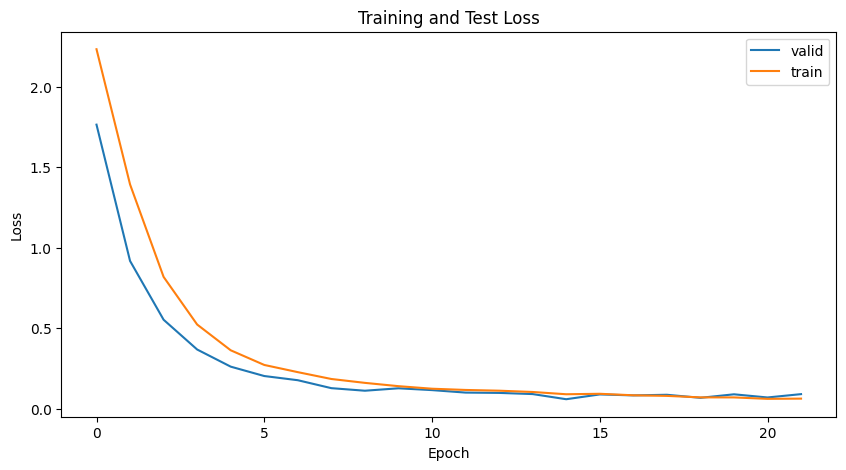

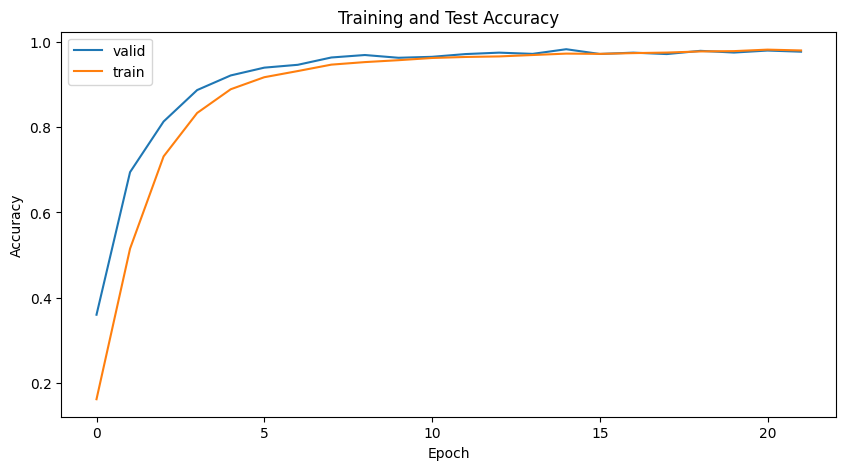

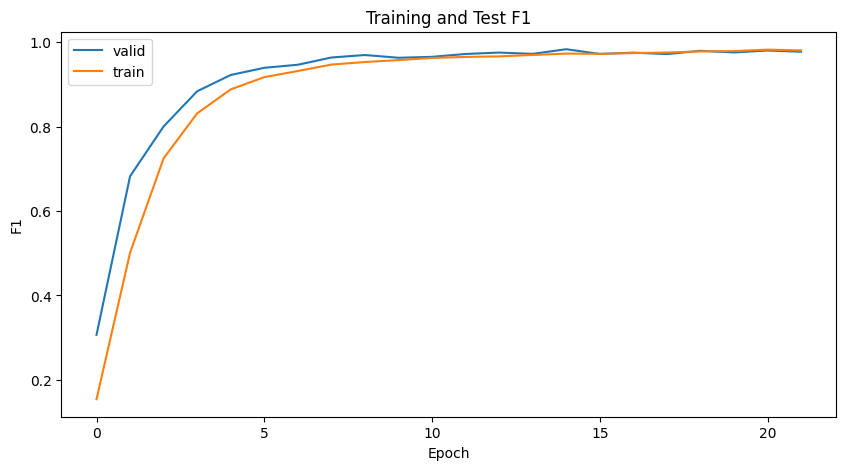

In [14]:
run_training(train_loader, val_loader, model, model_name, criterion, optimizer, config)

## Inference

In [15]:
class InferenceDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        super().__init__()
        self.images_dir = images_dir
        self.transform = transform

        self.images = os.listdir(images_dir)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_name = self.images[index]
        img_path = os.path.join(self.images_dir, img_name)

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # to submit to kaggle competition I need to return image name
        return img_name, image

In [16]:
def inference(test_loader, model, model_name, config):
    if model_name == 'resnet50' or model_name == 'resnet101':
        model.fc = nn.Linear(2048, 10)
    elif model_name == 'cvt_3' or model_name == 'cvt_7' or model_name == 'cvt_14':
        pass
    else:
        raise NotImplementedError('unknown architecture')
    
    model = model.to(config['DEVICE'])
    model.load_state_dict(torch.load(os.path.join(config['MODELS_DIR'], f'{model_name}_best_model.pth')))
    model.eval()
    
    df = pd.DataFrame()
    
    with torch.no_grad():
        for data in tqdm(test_loader, desc='Inference'):
            img_name, imgs = data
            imgs = imgs.to(config['DEVICE'])

            logits = model(imgs)
            probas = F.softmax(logits, dim=1)
            
            block = np.concatenate((np.array(img_name).reshape(-1, 1), probas.detach().cpu().numpy()), axis=1)
            block = pd.DataFrame(block, columns=['img', 'c0', 'c1', 'c2',
                                                 'c3', 'c4', 'c5',
                                                 'c6', 'c7', 'c8',
                                                 'c9'])
            df = pd.concat((df, block), axis=0, ignore_index=True)
    return df

In [17]:
test_transformations = val_transforms
test_dataset = InferenceDataset(config['TEST_DIR'], transform=test_transformations)
test_loader = DataLoader(test_dataset, batch_size=config['BATCH_SIZE'], shuffle=False, num_workers=config['NUM_WORKERS'])

# this csv file will be submitted to kaggle
df = inference(test_loader, model, model_name, config)

Inference: 100%|██████████| 1246/1246 [05:26<00:00,  3.81it/s]


In [19]:
df.to_csv(f'submission {model_name}.csv', index=False)